# Using labelled datasets to enrich our activity data

We have a couple of labelled datasets that we can use to enrich our health data with more meaningful categories about purposes, goals ans disease areas. In this notebook we will train predictive models in those data and then apply them to the GDB we have been working with in `notebook 3`.

Steps to follow:

* Preamble
* Load the data (GTR and RWJF)
* Train models 
* Evaluate models
* Save models


## Preamble

In [196]:
# %load preamble.py
%matplotlib inline
#NB I open a standard set of directories

#Paths

#Get the top path
top_path = os.path.dirname(os.getcwd())

#Create the path for external data
ext_data = os.path.join(top_path,'data/external')

#Raw path (for html downloads)

raw_data = os.path.join(top_path,'data/raw')

#And external data
proc_data = os.path.join(top_path,'data/processed')

fig_path = os.path.join(top_path,'reports/figures')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [197]:
#And the model path
mod_path = os.path.join(top_path,'models/')

#ML imports
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

import warnings

warnings.simplefilter('ignore',UserWarning)

In [52]:
# Utility functions

def flatten_list(my_list):
    '''
    Flattens a list
    '''
    
    return([x for el in my_list for x in el])


def dummies_from_list(list_of_categories):
    '''
    This function takes a list of categories and returns a df where every column is a dummie for each unique variable
    in the category. Admittedly, the function could be nicer.
    
    '''

    #We concatenate a bunch of series whose indices are the names of the variables.
    #We could have done something similar by creating DFs with one row
    dummy_df = pd.concat([pd.Series({v:1 for v in obs}) for obs in list_of_categories],axis=1).T.fillna(0)
    return(dummy_df)

In [262]:
# CLasses

#One class for text classification based on text inputs

class TextClassification():
    '''
    This class takes a corpus (could be a list of strings or a tokenised corpus) and a target (could be multiclass or single class).
    
    When it is initialised it vectorises the list of tokens using sklearn's count vectoriser.
    
    It has a grid search method that takes a list of models and parameters and trains the model.
    
    It returns the output of grid search for diagnosis
    
    '''
    
    def __init__(self,corpus,target):
        '''
        
        Initialise. The class will recognise if we are feeding it a list of strings or a list of
        tokenised documents and vectorise accordingly. 
        
        It will also recognise is this a multiclass or one class problem based on the dimensions of the target array
        
        Later on, it will use control flow to modify model parameters depending on the type of data we have
        
        '''
        
        #Is this a multiclass classification problem or a single class classification problem?
        if target.shape[1]>1:
            self.mode = 'multiclass'
            
        else:
            self.mode = 'single_class'
    
    
        #Store the target
        self.Y = target
    
        #Did we feed the model a bunch of strings or a list of tokenised docs? If the latter, we clean and tokenise.
        
        if type(corpus[0])==str:
            corpus = CleanTokenize(corpus).clean().bigram().tokenised
            
        #Turn every list of tokens into a string for count vectorising
        corpus_string =  [' '.join(words) for words in corpus]
        
        
        #And then we count vectorise in a hacky way.
        count_vect = CountVectorizer(stop_words='english',min_df=5).fit(corpus_string)
        
        #Store the features
        self.X = count_vect.transform(corpus_string)
        
        #Store the count vectoriser (we will use it later on for prediction on new data)
        self.count_vect = count_vect
        
    def grid_search(self,models):
        '''
        The grid search method takes a list with models and their parameters and it does grid search crossvalidation.
        
        '''
        
        #Load inputs and targets into the model
        Y = self.Y
        X = self.X
        
        if self.mode=='multiclass':
            '''
            If the model is multiclass then we need to add some prefixes to the model paramas
            
            '''
        
            for mod in models:
                #Make ovr
                mod[0] = OneVsRestClassifier(mod[0])
                
                #Add the estimator prefix
                mod[1] = {'estimator__'+k:v for k,v in mod[1].items()}
                
        
        #Container with results
        results = []

        #For each model, run the analysis.
        for num,mod in enumerate(models):
            print(num)

            #Run the classifier
            clf = GridSearchCV(mod[0],mod[1])

            #Fit
            clf.fit(X,Y)

            #Append results
            results.append(clf)
        
        self.results = results
        return(self)

    
#Class to visualise the outputs of multilabel models.

#I call it OrangeBrick after YellowBrick, the package for ML output visualisation 
#(which currently doesn't support multilabel classification)


class OrangeBrick():
    '''
    This class takes a df with the true classes for a multilabel classification exercise and produces some charts visualising findings.
    
    The methods include:
    
        .confusion_stack: creates a stacked barchart with the confusion matrices stacked by category, sorting classes by performance
        .prec_rec: creates a barchart showing each class precision and recall;
        #Tobe done: Consider mixes between classes?
    
    '''
    
    def __init__(self,true_labels,predicted_labels,var_names):
        '''
        Initialise with a true labels, predicted labels and the variable names
        '''
         
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.var_names = var_names
    
    def make_metrics(self):
        '''
        Estimates performance metrics (for now just confusion charts by class and precision/recall scores for the 0.5 
        decision rule.
        
        '''
        #NB in a confusion matrix in SKlearn the X axis indicates the predicted class and the Y axis indicates the ground truth.
        #This means that:
            #cf[0,0]-> TN
            #cf[1,1]-> TP
            #cf[0,1]-> FN (prediction is false, groundtruth is true)
            #cf[1,0]-> FP (prediction is true, ground truth is false)



        #Predictions and true labels
        true_labels = self.true_labels
        pred_labels = self.predicted_labels

        #Variable names
        var_names = self.var_names

        #Store confusion matrices
        score_store = []


        for num in np.arange(len(var_names)):

            #This is the confusion matrix
            cf = confusion_matrix(pred_labels[:,num],true_labels[:,num])

            #This is a melted confusion matrix
            melt_cf = pd.melt(pd.DataFrame(cf).reset_index(drop=False),id_vars='index')['value']
            melt_cf.index = ['true_negative','false_positive','false_negative','true_positive']
            melt_cf.name = var_names[num]
            
            #Order variables to separate failed vs correct predictions
            melt_cf = melt_cf.loc[['true_positive','true_negative','false_positive','false_negative']]

            #We are also interested in precision and recall
            prec = cf[1,1]/(cf[1,1]+cf[1,0])
            rec = cf[1,1]/(cf[1,1]+cf[0,1])

            prec_rec = pd.Series([prec,rec],index=['precision','recall'])
            prec_rec.name = var_names[num]
            score_store.append([melt_cf,prec_rec])
    
        self.score_store = score_store
        
        return(self)
    
    def confusion_chart(self,ax):
        '''
        Plot the confusion charts
        
        
        '''
        
        #Visualise confusion matrix outputs
        cf_df = pd.concat([x[0] for x in self.score_store],1)

        #This ranks categories by the error rates
        failure_rate = cf_df.apply(lambda x: x/x.sum(),axis=0).loc[['false' in x for x in cf_df.index]].sum().sort_values(
            ascending=False).index

        
        #Plot and add labels
        cf_df.T.loc[failure_rate,:].plot.bar(stacked=True,ax=ax,width=0.8,cmap='Accent')

        ax.legend(bbox_to_anchor=(1.01,1))
        #ax.set_title('Stacked confusion matrix for disease areas',size=16)
    
    
    def prec_rec_chart(self,ax):
        '''
        
        Plot a precision-recall chart
        
        '''
    

        #Again, we sort them here to assess model performance in different disease areas
        prec_rec = pd.concat([x[1] for x in self.score_store],1).T.sort_values('precision')
        prec_rec.plot.bar(ax=ax)

        #Add legend and title
        ax.legend(bbox_to_anchor=(1.01,1))
        #ax.set_title('Precision and Recall by disease area',size=16)

## 1. Load data

In [5]:
#Load GTR projects
gtr = pd.read_csv(ext_data+'/projects_gtr.csv')

#Load RWJF projeccts
#rwjf = pd.read_csv(ext_data+'/')


## 2. Predictive analysis

Here we carry out the predictive analysis of the GTR and RWJF data. 


### a. GTR


We start with the GTR data. Recall that there are projects with disease category information here, as well as projects in topics related to public health etc.




#### i. EDA

In [6]:
#The dict with health category info was loaded as a string so we need to parse it (evaluate it)

from ast import literal_eval

gtr['health_categories'] = [literal_eval(x) for x in gtr['health_categories']]

In [7]:
# We then extract health projects (those that have at least one health category)

In [11]:
health = gtr.loc[[len(x['healthCategory'])>0 for x in gtr['health_categories']]].reset_index(drop=True)

health.shape

(7174, 17)

seven thousand projects

In [14]:
#This is what one of the variables looks like.
health['health_categories'][0]

{'healthCategory': [{'id': '98954',
   'percentage': 100,
   'text': 'Generic Health Relevance'}]}

In [16]:
#We now create a list of health categories for each project
health['health_cat_list'] = [[x['text'] for x in health_cats['healthCategory']] for health_cats in health['health_categories']]

In [17]:
health_cat_flat = flatten_list(health['health_cat_list'])

len(set(health_cat_flat))

21

There are 21 categories

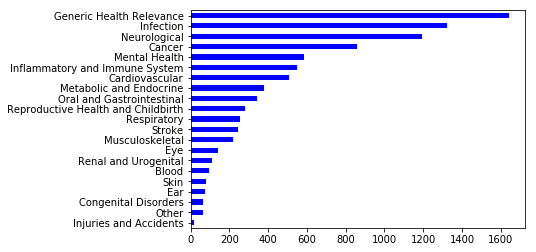

In [51]:
#This is what they look like
pd.Series(health_cat_flat).value_counts(ascending=True).plot.barh(color='blue')

(array([5.969e+03, 0.000e+00, 9.070e+02, 0.000e+00, 1.010e+02, 0.000e+00,
        5.900e+01, 0.000e+00, 1.340e+02, 4.000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

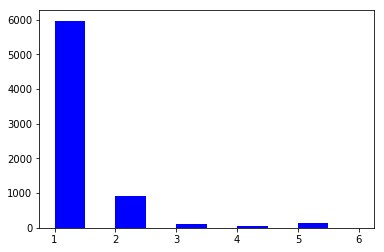

In [18]:
#How often do they co-occur?
plt.hist([len(x) for x in health['health_cat_list']],color='blue')

Perhaps not enough for a cluster analysis but then we don't have many categories to predict

In [97]:
#I have noticed that we have two sets of abstracts to consider here. 
health[['abstract_texts','tech_abstracts']].head()

#Could use both. Would need to normalise given that there seems to be some overlap between terms

,abstract_texts,tech_abstracts
0,"Your body is built of billions of cells, and t...",Our preliminary screen with siRNA against 13 m...
1,This research concerns a new aspect of human i...,There is growing evidence from animal and huma...
2,Abstracts are not currently available in GtR f...,Hutchinson-Gilford progeria syndrome (HGPS) is...
3,"Context of the research: \nWorldwide, alcohol ...","Background: In the UK alone, nearly 9% of men ..."
4,"Thyroid hormone (T3) excess causes bone loss, ...",Aims: Excess thyroid hormone (T3) accelerates ...


In [105]:
health[['abstract_texts','tech_abstracts']].isna().sum()

abstract_texts      0
tech_abstracts    671
dtype: int64

#### ii. Preprocessing

Import the LDA pipeline and process tech abstracts and abstract texts


In [22]:
%run lda_pipeline.py

import lda_pipeline

In [46]:
#These two lists are the tokenised abstracts.
# Important observation - we are dropping ~600 projects from the tech abstracts category where those abstracts are missing.
# We'll need to do the same thing with the targets.

#Drop all observations with missing tech abstracts
health_w_tech = health.dropna(axis=0,subset=['tech_abstracts'])

#Extract the tokenised descriptions for the remaining records
health_abs,health_tech_descr = [list(CleanTokenize(health_w_tech[var]).clean().bigram().tokenised) for var in 
                                ['abstract_texts','tech_abstracts']]
                                

In [47]:
#Then create the category dummies.

In [48]:
health_cat_dummies = dummies_from_list(health_w_tech['health_cat_list'])

In [50]:
health_cat_dummies.head()

,Blood,Cancer,Cardiovascular,Congenital Disorders,Ear,Eye,Generic Health Relevance,Infection,Inflammatory and Immune System,Injuries and Accidents,...,Metabolic and Endocrine,Musculoskeletal,Neurological,Oral and Gastrointestinal,Other,Renal and Urogenital,Reproductive Health and Childbirth,Respiratory,Skin,Stroke
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
#Turn this into an array for pred analysis
Y = np.array(health_cat_dummies)

#### iii. Modelling

We use a simple class we wrote for this kind of predictive analysis.

In [69]:
#Initialise class
tc = TextClassification(health_abs,Y)

In [81]:
#Run grid search with these model parameters
models = [
    [RandomForestClassifier(),
     {'class_weight':['balanced',None],'min_samples_leaf':[1,5]}],
    
    [LogisticRegression(),
     {'class_weight':['balanced',None],'penalty':['l1','l2'],
      'C':[0.1,1,100]}]]

tc.grid_search(models)

0
1


In [85]:
#Check scores and best estimators
for res in tc.results:
    print(res.best_score_)
    print(res.best_estimator_)
    

0.35752729509457176
OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=1)
0.533138551437798
OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=1)


In [86]:
#This is the best estimator
best_est = tc.results[1].best_estimator_

Some exploration of the results

In [255]:
from sklearn.metrics import confusion_matrix

Text(0.5,1.01,'Model evaluation for GTR topics')

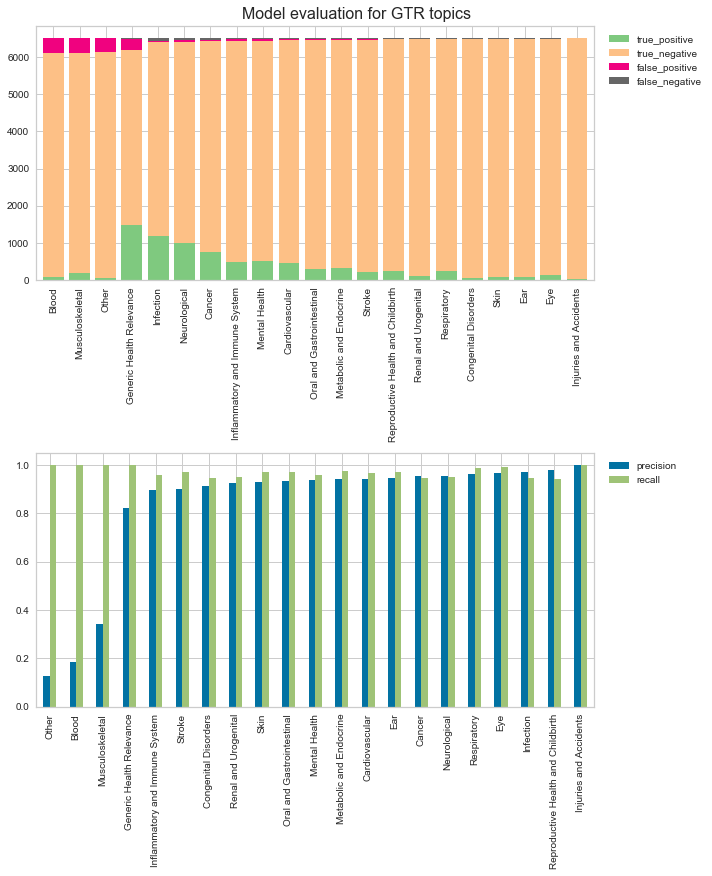

In [260]:
gtr_diag = OrangeBrick(Y,best_est.predict(tc.X),health_cat_dummies.columns).make_metrics()

fig,ax = plt.subplots(nrows=2,figsize=(10,12))

gtr_diag.confusion_chart(ax=ax[0])
gtr_diag.prec_rec_chart(ax=ax[1])

plt.tight_layout()

fig.suptitle('Model evaluation for GTR topics',y=1.01,size=16)

The model performs less well in the 'Blood', 'Musculoeskeletal' and 'Other' categories

We have 3-4 categories with poor model performance (unsurprisingly including other) after which prevision becomes quite good.

TODO: Explore errors un Blood, musculoeskeletal variables. What is the mixing between them and other disease areas?


In [200]:
#We save the model for use in the bigger GDB

with open(mod_path+'/{date}_gtr_disease_models.p'.format(date=today_str),'wb') as outfile:
    pickle.dump([tc.count_vect,best_est,var_names],outfile)

### b. RWJF

#### i. Load data and EDA

In [211]:
# Load data (obtained from George)

rwj = pd.read_csv(ext_data+'/rwjf_grants_05_18_2018.csv')

#We drop projects without an about (features) or topics (target)
rwj = rwj.dropna(axis=0,subset=['about','topics'])
rwj.shape

(6834, 16)

In [212]:
rwj.head()

,about,address,amount_awarded,awarded,awarded_on,contacts,grant_number,location,organization,page,timeframe,title,topics,website,year,about_tokenized
0,The Robert Wood Johnson Clinical Scholars Prog...,University of North Carolina at Chapel Hill Sc...,"$865,484","$865,484",3/25/2009,Desmond Kimo Runyan,48349,"Chapel Hill, NC",University of North Carolina at Chapel Hill Sc...,1344,5/1/2009 - 4/30/2010,Technical assistance and direction for the Rob...,Health Disparities\nHealth Leadership Development,http://www.med.unc.edu/contact,2009,"['robert_wood', 'johnson', 'clinical', 'schola..."
1,The Robert Wood Johnson Clinical Scholars Prog...,University of North Carolina at Chapel Hill Sc...,"$801,175","$801,175",3/8/2010,Desmond Kimo Runyan,48350,"Chapel Hill, NC",University of North Carolina at Chapel Hill Sc...,1201,5/1/2010 - 4/30/2011,Technical assistance and direction for the Rob...,Health Disparities\nHealth Leadership Development,http://www.med.unc.edu/contact,2010,"['robert_wood', 'johnson', 'clinical', 'schola..."
2,This grant will continue long-standing support...,National Public Radio Inc.\n1111 North Capital...,"$2,800,000","$2,800,000",11/13/2008,Anne Gudenkauf,51491,"Washington, DC",National Public Radio Inc.,1391,11/15/2008 - 11/14/2011,Health and health care reporting by National P...,Public and Community Health\nHealth Care Quality,http://www.npr.org/,2008,"['grant', 'continue', 'long', 'standing', 'sup..."
4,The Foundation's Summer Medical and Dental Edu...,Association of American Medical Colleges\n655 ...,"$1,252,432","$1,252,432",8/7/2008,Charles Terrell\nRichard W. Valachovic,53039,"Washington, DC",Association of American Medical Colleges,1444,9/1/2008 - 8/31/2009,Technical assistance and direction for RWJF's ...,Social Determinants of Health\nHealth Leadersh...,http://www.aamc.org,2008,"['foundation', 'summer', 'medical_dental', 'ed..."
5,Although the Robert Wood Johnson Foundation be...,"Center School\n2 Riverview Drive\nSomerset, NJ...","$65,000","$65,000",5/12/2009,Susan Osborn,53357,"Somerset, NJ",Center School,1328,6/1/2009 - 9/30/2009,"Summer therapy program for high-risk, learning...",Mental and Emotional Well-Being\nDisease Preve...,http://www.thecenterschool.com/,2009,"['robert_wood_johnson_foundation', 'national_p..."


TODO: decide what to repeat about repeated references (eg see rows 0 and 1 above - they capture the same programme in consecutive years)

#### ii. Preprocessing

In [209]:
# No need to preprocess and tokenise the features (they were included in the data)

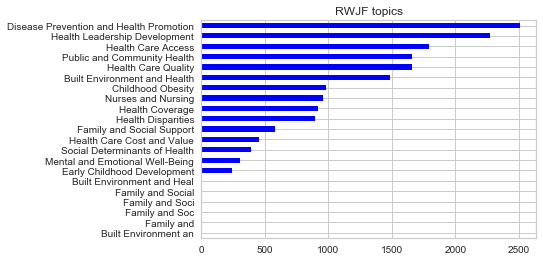

In [227]:
rwj['topic_list'] = [x.split('\n') for x in rwj['topics']]

pd.Series(flatten_list(rwj['topic_list'])).value_counts(ascending=True).plot.barh(color='blue',title='RWJF topics')

There is a small number of typos we don't want to consider

In [229]:
#We will remove typo topics
rwj_topic_count = pd.Series(flatten_list(rwj['topic_list'])).value_counts(ascending=True)
rwj_topic_keep = rwj_topic_count.index[rwj_topic_count>10]

#Filter each topic list to keep relevant non-typo topics
rwj['topic_list'] = [[x for x in topic_list if x in rwj_topic_keep] for topic_list in rwj['topic_list']]

In [231]:
#Create targets (dummies) with the function we defined above
rwj_topic_dummies = dummies_from_list(rwj['topic_list'])

In [264]:
#Create array and list of wrj variables
Y = np.array(rwj_topic_dummies)
rwj_topic_names = rwj_topic_dummies.columns

#### iii. Modelling

In [235]:
#Initialise the TextClassification class
rwj_topic = TextClassification(rwj['about_tokenized'],Y)

In [236]:
#Do grid search with the same models we used in the analysis before
rwj_topic.grid_search(models=models)

0
1


In [237]:
#Check scores and best estimators
for res in rwj_topic.results:
    print(res.best_score_)
    print(res.best_estimator_)

0.14076675446297923
OneVsRestClassifier(estimator=OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1),
          n_jobs=1)
0.1874451273046532
OneVsRestClassifier(estimator=OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1),
          n_jobs=1)


Model performance is much worse than what we achieved when analysing the GTR data. This could be due to the fact that the vocabulary associated with the RWJF topics is more generic. There are some things we could do to address this such as TFIDF etc.

Text(0.5,1.01,'Model evaluation for RWJF topics')

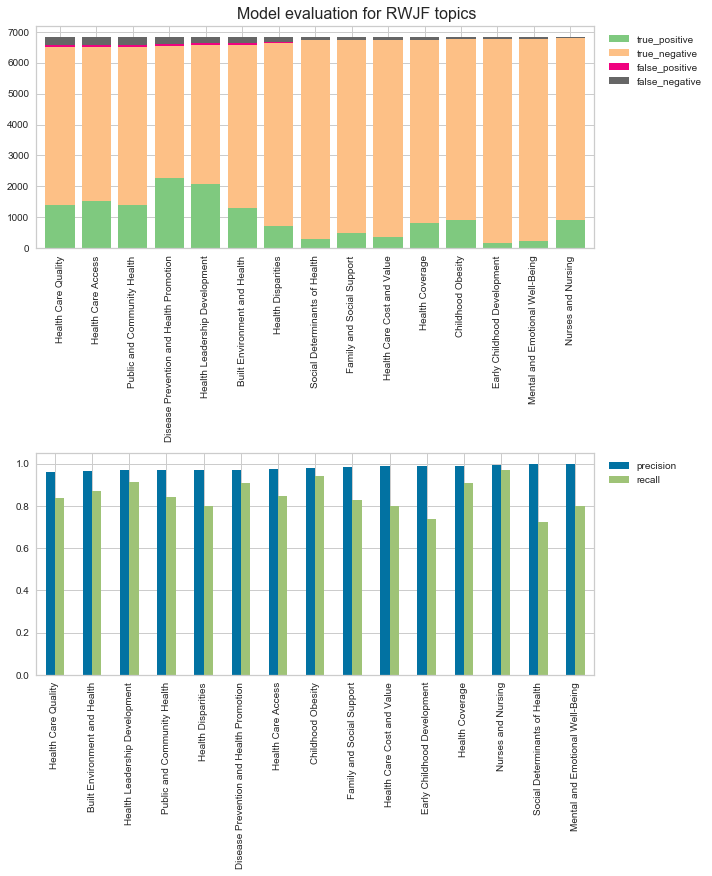

In [266]:
rwj_diag = OrangeBrick(rwj_topic.Y,rwj_topic.results[1].best_estimator_.predict(rwj_topic.X),rwj_topic_names).make_metrics()

fig,ax = plt.subplots(nrows=2,figsize=(10,12))

rwj_diag.confusion_chart(ax=ax[0])
rwj_diag.prec_rec_chart(ax=ax[1])

plt.tight_layout()

fig.suptitle('Model evaluation for RWJF topics',y=1.01,size=16)

Observations: The model seems to perform quite well when we consider classes separately. Worst classes are Health Care Quality and Health Care Access when we look at the confusion matrix



In [267]:
#We save the model for use in the bigger GDB

with open(mod_path+'/{date}_rwj_topics.p'.format(date=today_str),'wb') as outfile:
    pickle.dump([rwj_topic.count_vect,rwj_topic.results[1].best_estimator_,rwj_topic_names],outfile)

## Check the presence of 'health topics' in the research subjects

In [76]:
projects['research_topics_parsed'] = [literal_eval(x) for x in projects.research_topics]

In [77]:
projects['research_topics_list'] = [[x['text'].lower() for x in top['researchTopic']] for top in projects['research_topics_parsed']]

In [79]:
health_topics = [x for x in set(flatten_list(projects['research_topics_list'])) if any(h in x for h in ['health','ill'])]

In [88]:
#How many projects have these topics?

#668 projects with health topics in them
#np.sum([len(set(health_topics) & set(x))>0 for x in projects['research_topics_list']])

projects_w_h = projects.loc[[len(set(health_topics) & set(x))>0 for x in projects['research_topics_list']],:].reset_index(drop=True)

In [90]:
projects_w_h.shape

(688, 19)

In [103]:
#What would be the features?
projects_w_h[['abstract_texts','tech_abstracts']].head()

,abstract_texts,tech_abstracts
0,<p>The project will produce teaching packs for...,NaN
1,South Asia has long had a fish eating traditio...,NaN
2,This research will investigate the chemical se...,Nutrient sensing by enteroendocrine cells (EEC...
3,"Atmospheric aerosol particles, or particulate ...",NaN
4,Manufactured nanoparticles (NPs) can be define...,NaN


In [106]:
projects_w_h[['abstract_texts','tech_abstracts']].isna().sum()

abstract_texts      0
tech_abstracts    540
dtype: int64